# Linear Discriminant Analysis from Scratch: Credit Default

- [Lab 1: Visualizing the Data ](#Visualizing-the-data)
- [Lab 2: LDA from Scratch](#LDA-from-Scratch)
- [Lab 3: Sklearn: LDA](#Sklearn)








### The objective is to create Linear Discriminant Analysis implementation using NumPy. Implementing basic models is a great idea to improve your comprehension about how they work.

### I'm building a Linear Discriminant Analysis from scratch and applying it with the Credit Default dataset, and then using Sklearn package for LogisticRegression to see if I get similar prediction results. This is just a toy exercice with teaching objectives.

### The simulated Customer default records from a made up credit card company. The simulated dataset is partially exported from package 'ISLR' from R with added on features such as: Age, LTI,  and Monthly Payments Delayed. 

### The data is made up and it is not applicable on any actual company. I'm interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. The statistical methods that I'm following through are based from "An Introduction to Statistical Learning with Applications in R"

In [6]:

import pandas as pd
import numpy as np
import math
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations_with_replacement





In [7]:
from numpy import linalg


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import datasets

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

# removing zero LTI 
df = df[df['LTI']!= 0]
df.head(3)

,ID,default,student,balance,income,Age,LTI,Months Delayed,default2,student2
0,1,No,No,729.526495,44361.625074,50.0,0.016445,0,0,0
1,2,No,Yes,817.180407,12106.134700,25.0,0.067501,0,0,1
2,3,No,No,1073.549164,31767.138947,39.0,0.033794,0,0,0


### Visualizing the data

/Users/michael/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/michael/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


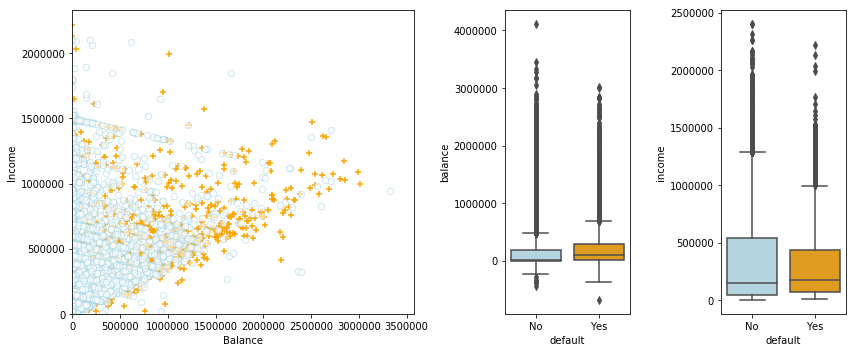

In [6]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

In [7]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,26601,5295
Yes,5646,1227


## Lab 2

### LDA from Scratch

In [14]:
def normalize(X , axis =1, order=2):
    '''normalize the dataset'''
    l2 = np.atleast_1d(np.linalg.norm(X,order,axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2,axis)

def standardize(X):
    '''standardize the dataset'''
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:,col] = (X_std[:,col] - mean[col]) / std[col]
            print(X_std)
    return X_std


def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

### Creating the class LDA

In [15]:
from __future__ import print_function, division
class LDA_Scratch():

    def __init__(self):
        self.w = None

    def transform(self, X, y):
        self.fit(X, y)
        # Project data onto vector
        X_transform = X.dot(self.w)

        return X_transform

    def fit(self, X, y):
        # Separate data by class
        X1 = X[y == 0]
        X2 = X[y == 1]

        # Calculate the covariance matrices of the two datasets
        covariance_1 = covariance_matrix(X1)
        covariance_2 = covariance_matrix(X2)
        
        covariance_total = covariance_1 + covariance_2
        
        print(covariance_total)
        
        # Calculate the mean of the two datasets
        mean_1 = X1.mean(0)
        mean_2 = X2.mean(0)
        mean_difference = np.atleast_1d(mean_1 - mean_2)
        
        print(mean_difference)
        
        # Determine the vector which when X is projected onto it best separates the
        # data by class. w = (mean_1 - mean_2) / (covariance_1 + covariance_2)
        
        self.w = np.linalg.pinv(covariance_total).dot(mean_difference)

    def predict(self, X):
        y_pred = []
        for sample in X:
            h = sample.dot(self.w)
            y = 1 * (h < 0)
            y_pred.append(y)
        return y_pred

In [25]:
def main():
    # Load the dataset
    data = datasets.load_iris()
    X = data.data
    y = data.target

    # Three -> two classes
    X = X[y != 2]
    y = y[y != 2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Fit and predict using LDA
    lda = LDA_Scratch()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)
    df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_pred})
    df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

    df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')
        #Plot().plot_in_2d(X_test, y_pred, title="LDA", accuracy=accuracy)
    print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
    print(classification_report(y_test, y_pred))
if __name__ == "__main__":
    main()
    

[[0.36572248 0.15804557 0.17139478 0.06084281]
 [0.15804557 0.21366718 0.08665131 0.05700358]
 [0.17139478 0.08665131 0.22886559 0.08124962]
 [0.06084281 0.05700358 0.08124962 0.05200128]]
[-0.86917563  0.67562724 -2.7938172  -1.07894265]
Accuracy: 1.0
True default status         No   Yes
Predicted default status            
No                        19.0   NaN
Yes                        NaN  14.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [16]:
X = df[['balance','income', 'Age', 'LTI','Months Delayed', 'student2']].values

y = df.default2.values

# Three -> two classes
X = X[y != 2]
y = y[y != 2]

seed = 8675309
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Fit and predict using LDA
lda = LDA_Scratch()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)
df_ = pd.DataFrame({'True default status': y_test,
                'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
print(classification_report(y_test, y_pred))



[[ 2.34949895e+11  6.71810545e+10  1.91377885e+05  3.78692780e+05
  -1.77450730e+05 -3.51209866e+04]
 [ 6.71810545e+10  2.44737051e+11  5.06991142e+05 -1.21761891e+05
   1.07490795e+05 -7.24712931e+04]
 [ 1.91377885e+05  5.06991142e+05  2.27235592e+02 -8.55457378e-01
  -5.62044097e-01 -4.67969145e+00]
 [ 3.78692780e+05 -1.21761891e+05 -8.55457378e-01  2.18006063e+00
  -3.57846040e-01  3.04596914e-03]
 [-1.77450730e+05  1.07490795e+05 -5.62044097e-01 -3.57846040e-01
   4.25793007e+00 -3.69760802e-02]
 [-3.51209866e+04 -7.24712931e+04 -4.67969145e+00  3.04596914e-03
  -3.69760802e-02  2.98631497e-01]]
[-6.88755413e+04  3.56271965e+04  1.66230665e+00 -5.03098289e-01
 -7.78719311e-01 -1.81505190e-02]
Accuracy: 0.6277342137845646
True default status         No   Yes
Predicted default status            
No                        4880   424
Yes                       3184  1204
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      8064
        

In [17]:
# Fit and predict using LDA
lda = LDA_Scratch()
lda.fit(X,y)
y_pred = lda.predict(X)

accuracy = accuracy_score(X, y_pred)

print ("Accuracy:", accuracy)
df_ = pd.DataFrame({'True default status': y,
                'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
print(classification_report(y, y_pred))



[[ 2.34476477e+11  6.59377650e+10  2.01502685e+05  3.79717112e+05
  -1.75511761e+05 -3.41704411e+04]
 [ 6.59377650e+10  2.43249799e+11  5.00818236e+05 -1.21513308e+05
   1.09493399e+05 -7.15747801e+04]
 [ 2.01502685e+05  5.00818236e+05  2.26974762e+02 -8.19863052e-01
  -2.39251255e-01 -4.66546928e+00]
 [ 3.79717112e+05 -1.21513308e+05 -8.19863052e-01  2.07804948e+00
  -3.61738981e-01  3.45642443e-03]
 [-1.75511761e+05  1.09493399e+05 -2.39251255e-01 -3.61738981e-01
   4.22245653e+00 -4.48115646e-02]
 [-3.41704411e+04 -7.15747801e+04 -4.66546928e+00  3.45642443e-03
  -4.48115646e-02  2.97197476e-01]]
[-6.87542715e+04  3.54034400e+04  1.53201931e+00 -5.05179516e-01
 -7.67050351e-01 -1.30464202e-02]
Accuracy: 0.0
True default status          No   Yes
Predicted default status             
No                        19601  1700
Yes                       12646  4822
              precision    recall  f1-score   support

           0       0.92      0.61      0.73     32247
           1       

/Users/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Sklearn

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_test))
# Fit and predict using LDA
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


9692
Accuracy: 0.8277961205117623
              precision    recall  f1-score   support

          No       0.84      0.98      0.90      8064
         Yes       0.44      0.09      0.15      1628

    accuracy                           0.83      9692
   macro avg       0.64      0.53      0.53      9692
weighted avg       0.77      0.83      0.78      9692



the LDA and logistic regression predictions are almost identical with 83% accuracy score. The LDA output indicates that πˆ1 = 0.84 and πˆ2 = 0.44; in other words, 84% of the training observations correspond to credit scores that are not defaulting. It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of μk. 

In [29]:
X = df[['balance','income']].values

y = df.default2.values

lda = LinearDiscriminantAnalysis(solver='lsqr')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
print(classification_report(y, y_pred))


True default status          No   Yes
Predicted default status             
No                        32221  6515
Yes                          26     7
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     32247
           1       0.21      0.00      0.00      6522

    accuracy                           0.83     38769
   macro avg       0.52      0.50      0.45     38769
weighted avg       0.73      0.83      0.76     38769



In [30]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.83      1.00      0.91     32247
         Yes       0.21      0.00      0.00      6522

    accuracy                           0.83     38769
   macro avg       0.52      0.50      0.45     38769
weighted avg       0.73      0.83      0.76     38769



### Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

the Bayes classifier, and by extension LDA, uses a threshold of 50 % for the posterior probability of default in order to assign an observation to the default class. However, if we are concerned about incorrectly pre- dicting the default status for individuals who default, then we can consider lowering this threshold. For instance, we might label any customer with a posterior probability of default above 20% to the default class.

In [35]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
print(classification_report(y, y_pred))

True default status          No   Yes
Predicted default status             
No                        28873  5472
Yes                        3374  1050
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     32247
           1       0.21      0.00      0.00      6522

    accuracy                           0.83     38769
   macro avg       0.52      0.50      0.45     38769
weighted avg       0.73      0.83      0.76     38769

